In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import matplotlib.patches as patches

In [3]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist
pynrc.setup_logging('WARNING', verbose=False)

In [ ]:
from astropy.io import ascii
from copy import deepcopy

# Observation Definitions

Functions to create at optimize a series of observation objects stored as a dictionary.

In [4]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [5]:
def spec_modify(sp_sci, kmag_sci, args_disk):
    """
    2MASS K-Band mags include disk flux.
    Modify stellar spectrum to exclude disk flux
    """

    # Determine real stellar spectrum. 2MASS K-Band mags include disk flux!
    filt = 'F210M'
    bp = pynrc.read_filter(filt)
    obs_sci = S.Observation(sp_sci, bp, binset=bp.wave)
    tot_flux = obs_sci.effstim('counts')
    hdu_disk = model_to_hdulist(args_disk, sp_sci, filt)
    disk_flux = hdu_disk[0].data.sum()
    star_flux = tot_flux - disk_flux

    # Value to scale stellar flux
    scale = star_flux / tot_flux
    kmag_sci_new = kmag_sci - 2.5*np.log10(star_flux / tot_flux)
    sp_sci2 = sp_sci.renorm(kmag_sci_new, 'vegamag', bp_k)
    sp_sci2.name = sp_sci.name
    return sp_sci2

In [270]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None, args_disk=None, fov_pix=None, verbose=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations. This function will calculate PSFs out to 160 pixels. 
    However, for the case of F200W+MASK335R, we will assume that the 
    subarray size matches that of a simultaneous LW observation (320x320).
    """
    if sp_ref is None:
        sp_ref = sp_sci
        
    obs_dict = {}
    for filt, mask, pupil in filt_list:
        if verbose: print(filt, mask, pupil)

        # Disk Model
        if args_disk is not None:
            # Convert to photons/sec in specified filter
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)
        else:
            hdu_disk = None
        
        # Create identification keys
        key = make_key(filt, mask=mask, pupil=pupil)

        # Define the subarray readout size
        # Set the PSF size and oversampling amount
        fov_pix_orig = fov_pix
        if fov_pix is None:
            fov_pix = subsize = 64 if mask is None else 320
        oversample = 2

        # Initialize and store the observation
        # A reference obseration is stored inside each parent obs_coronagraphy class.
        obs_dict[key] = pynrc.obs_coronagraphy(sp_sci, sp_ref, dist, 
                                               disk_hdu=hdu_disk, wfe_drift=wfe_drift,
                                               filter=filt, mask=mask, pupil=pupil, 
                                               oversample=oversample, fov_pix=fov_pix,
                                               wind_mode='WINDOW', xpix=subsize, ypix=subsize,
                                               verbose=verbose)
        fov_pix = fov_pix_orig
    return obs_dict

In [7]:
def obs_optimize(obs_dict, sp_opt=None, well_levels=None, tacq_max=1800, **kwargs):
    """
    Perform ramp optimization on each science and reference observation
    in a list of filter observations. Updates the detector MULTIACCUM
    settings for each observation in the dictionary.
    
    snr_goal = 5
    snr_frac = 0.02
    tacq_max = 1400
    tacq_frac = 0.01
    nint_min = 15
    ng_max = 10
    """

    # A very faint bg object on which to maximize S/N
    # If sp_opt is not set, then default to a 20th magnitude flat source
    if sp_opt is None:
        bp_k = S.ObsBandpass('k')
        sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)

    
    # Some observations may saturate, so define a list of  maximum well level
    # values that we will incrementally check until a ramp setting is found
    # that meets the contraints.
    if well_levels is None:
        well_levels = [0.8, 1.5, 3.0, 5.0, 10.0, 20.0, 100.0, 150.0, 300.0, 500.0]
   
    filt_keys = obs_dict.keys()
    filt_keys.sort()
    print(['Pattern', 'NGRP', 'NINT', 't_int', 't_exp', 't_acq', 'SNR', 'Well', 'eff'])
    for j, key in enumerate(filt_keys):
        print('')
        print(key)

        obs = obs_dict[key]
        sp_sci, sp_ref = (obs.sp_sci, obs.sp_ref)

        sci = obs
        ref = sci.nrc_ref
            
        # Ramp optimization for both science and reference targets
        for obs2, sp in zip([sci, ref], [sp_sci, sp_ref]):
            i = nrow = 0
            while nrow==0:
                well_max = well_levels[i]
                tbl = obs2.ramp_optimize(sp_opt, sp, well_frac_max=well_max, tacq_max=tacq_max, **kwargs)
                nrow = len(tbl)
                i+=1
                
            # Grab the highest ranked MULTIACCUM settings and update the detector readout
            v1, v2, v3 = tbl['Pattern', 'NGRP', 'NINT'][0]
            
            vals = tbl[0].as_void()
            strout = ', '.join(map(str, vals))
            print(strout)

            # SW filter piggy-back on two LW filters, so 2 x tacq
            # Only for Debris Disk program
            #is_SW = obs.bandpass.avgwave()/1e4 < 2.5
            #if is_SW: v3 *= 2
            
            # Coronagraphic observations have two roll positions, so cut NINT by 2
            if obs.mask is not None: v3 = int(v3/2)
            obs2.update_detectors(read_mode=v1, ngroup=v2, nint=v3)
        

## Plotting contrasts and planet magnitudes

In [8]:
def plot_contrasts(curves, wfe_list, ax=None, colors=None, return_ax=False):
    """Plot a series of contrast curves for corresponding WFE drifts."""
    if ax is None:
        fig, ax = plt.subplots()
    if colors is None:
        lin_vals = np.linspace(0.2,0.7,len(wfe_list))
        colors = plt.cm.Blues_r(lin_vals)[::-1]
    for j, wfe_drift in enumerate(wfe_list):
        rr, contrast, mag_sens = curves[j]
        label="WFE Drift = {} nm".format(wfe_list[j])
        ax.plot(rr, mag_sens, label=label, color=colors[j], zorder=1, lw=2)
        
    if return_ax: return ax


def planet_mags(obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25]):
    """Determine series of exoplanet magnitudes for given observation."""

    pmag = {}
    for i,m in enumerate(mass_list):
        flux_list = []
        for j,av in enumerate(av_vals):
            sp = obs.planet_spec(mass=m, age=age, Av=av, entropy=entropy, atmo='hy3s')
            sp_obs = S.Observation(sp, obs.bandpass, binset=obs.bandpass.wave)
            flux = sp_obs.effstim('vegamag')
            flux_list.append(flux)
        pmag[m] = tuple(flux_list)
        
    return pmag

        
def plot_planet_patches(ax, obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25]):
    """Plot exoplanet magnitudes in region corresponding to extinction values."""
    
    xlim = ax.get_xlim()
    cols = plt.cm.tab10(np.linspace(0,1,10))
    
    dist = obs.distance
    
    pmag = planet_mags(obs, age, entropy, mass_list, av_vals)
    for i,m in enumerate(mass_list):
        pm_min, pm_max = pmag[m]
        label = 'Mass = {} '.format(m) + '$M_{\mathrm{Jup}}$'
        rect = patches.Rectangle((xlim[0], pm_min), xlim[1], pm_max-pm_min, alpha=0.2,
                                 color=cols[i], label=label, zorder=2)
        ax.add_patch(rect)
        ax.plot(xlim, [pm_min]*2, color=cols[i], lw=1, alpha=0.3)
        ax.plot(xlim, [pm_max]*2, color=cols[i], lw=1, alpha=0.3)
        

    entropy_switch = {13:'Hot', 8:'Cold'}
    entropy_string = entropy_switch.get(entropy, lambda: "Warm")
    ent_str = entropy_string + ' Start'
    #ent_str = '{} Start'.format(entropy_string)

    av_str = '$A_V = [{:.0f},{:.0f}]$'.format(av_vals[0],av_vals[1])
    age_str = 'Age = {:.0f} Myr; '.format(age)
    dist_str = 'Dist = {:.1f} pc; '.format(dist) if dist is not None else ''
    #dist_str=""

    ax.set_title('{} -- {} ({}{}{})'.format(obs.filter,ent_str,age_str,dist_str,av_str))


In [9]:
def plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, save_fig=False):
    nfilt = len(filt_keys)
    ext_name = ['Model', 'Sim Image (linear scale)', 'Sim Image ($r^2$ scale)']
    nim = len(ext_name)

    fig, axes = plt.subplots(nim, nfilt, figsize=(14,7.5))
    axes = axes.transpose()
    for j, k in enumerate(filt_keys):
        obs = obs_dict[k]
        hdu_mod = obs.disk_hdulist
        hdu_sim = hdu_dict[k]

        # Make r^2 scaled version of data
        hdu_sim_r2 = deepcopy(hdu_sim)
        data  = hdu_sim_r2[0].data
        header = hdu_sim_r2[0].header
        rho = nrc_utils.dist_image(data, pixscale=header['PIXELSCL'])
        data *= rho**2

        # Max value for model
        data_mod   = hdu_mod[0].data
        header_mod = hdu_mod[0].header
        rho_mod    = nrc_utils.dist_image(data_mod, pixscale=header_mod['PIXELSCL'])
        data_mod_r2 = data_mod*rho_mod**2
        vmax  = np.max(data_mod)
        vmax2 = np.max(data_mod_r2)
        
        # Scale value for data
        mask_good = data_mod>(0.1*vmax)
        scl1 = np.median(hdu_sim[0].data[mask_good] / data_mod[mask_good])
        
        # Scale value for r^2 version
        mask_good = data_mod_r2>(0.1*vmax2)
        scl2 = np.median(hdu_sim_r2[0].data[mask_good] / data_mod_r2[mask_good])

        vmax_vals = [vmax,vmax*scl1,vmax2*scl2]
        hdus = [hdu_mod, hdu_sim, hdu_sim_r2]
        for i, ax in enumerate(axes[j]):
            hdulist = hdus[i]
            data = hdulist[0].data
            header = hdulist[0].header

            pixscale = header['PIXELSCL']
            rho = nrc_utils.dist_image(data, pixscale=pixscale)

            rad = data.shape[0] * pixscale / 2
            extent = [-rad, rad, -rad, rad]

            ax.imshow(data, vmin=0, vmax=0.9*vmax_vals[i], extent=extent)

            ax.set_aspect('equal')
            if j > 0: ax.set_yticklabels([])
            if i < nim-1: ax.set_xticklabels([])
            if i==nim-1: ax.set_xlabel('Arcsec')
            if j==0: ax.set_ylabel(ext_name[i])

            if i==0: ax.set_title(obs.filter)

            if fov>2*rad:
                xlim = [-rad,rad]
                ylim = [-rad,rad]
            else:
                xlim = [-fov/2,fov/2]
                ylim = [-fov/2,fov/2]
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

            ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
            ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

            ax.tick_params(axis='both', color='white', which='both')
            for k in ax.spines.keys():
                ax.spines[k].set_color('white')

            
    texp = obs_dict[filt_keys[-1]].multiaccum_times['t_exp']
    texp = round(2*texp/100)*100
    exp_text = "t_exp = {:.0f} sec".format(texp)
    wfe_text = "WFE Drift = {} nm".format(wfe_drift)
    fig.suptitle('{} ({}; {})'.format(name_sci, exp_text, wfe_text), fontsize=16);
    fig.tight_layout()

    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9, bottom=0.07 , left=0.05, right=0.97)
    
    fname = "{}_images.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

## Functions to init, optimize, and plot contrast

In [10]:
# Generate initial observations for each filter(no WFE drift)
def do_init(args_disk=None, fov_pix=None, verbose=True):
    wfe_drift = 0
    obs_dict = obs_wfe(wfe_drift, args_list, sp_sci, dist_sci, sp_ref=sp_ref, 
                       args_disk=args_disk, fov_pix=fov_pix, verbose=verbose)
    return obs_dict

In [11]:
# Optimize observations
def do_opt(tacq_max, **kwargs):
    sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)
    obs_optimize(obs_dict, sp_opt=sp_opt, tacq_max=tacq_max, **kwargs)

In [12]:
# For each filter setting, generate a series of contrast curves at different WFE values
def do_contrast(wfe_list, filt_keys, nsig=5, roll_angle=None):
    contrast_all = {}
    for i, key in enumerate(filt_keys):
        print(key)
        obs = obs_dict[key]

        filt, mask, pupil = args_list[i]
        if roll_angle is None:
            roll_angle = 0 if mask is None else 10

        # Stores tuple of (Radial Distances, Contrast, and Sensitivity) for each WFE drift
        curves = []
        for wfe_drift in wfe_list:
            obs.wfe_drift = wfe_drift
            result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig)
            curves.append(result)

        contrast_all[key] = curves
    return contrast_all

In [13]:
def do_plot_contrast(obs, curves, wfe_list, nsig, age, xlim=[0,10], ylim=[24,8], save_fig=False):

    fig, axes = plt.subplots(1,2, figsize=(13,4.5))
    entropy_vals = [13,8]

    for j, ax in enumerate(axes.flatten()):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plot_contrasts(curves, wfe_list, ax=ax)
        plot_planet_patches(ax, obs, age=age, entropy=entropy_vals[j])

    for ax in axes.flatten():
        ax.set_xlabel('Distance (arcsec)')
        ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.legend(ncol=2)

    fig.tight_layout()
    
    t_exp = obs.multiaccum_times['t_exp']
    t_exp = round(2*t_exp/100)*100
    fig.suptitle('{} (t_exp = {:.0f} sec)'.format(name_sci, t_exp), fontsize=16);
    #fig.subplots_adjust(top=0.85)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)

    fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

In [15]:
def do_gen_hdus(obs_dict, wfe_drift, **kwargs):
    
    hdulist_dict = {}
    for key in filt_keys:
        obs = obs_dict[key]
        obs.wfe_drift = wfe_drift
        hdulist = obs.gen_roll_image(PA1=0, PA2=10, **kwargs)
        
        hdulist_dict[key] = hdulist
        
    return hdulist_dict

## Define Source and their Reference Counterparts

In [271]:
#                source,      dist, age, sptype, kmag
args_sources = [('SAO 206462', 140,  10, 'F8V',   5.8),
                ('TW Hya',      54,  10, 'M0V',   7.3),
                ('MWC 758',    280,   5, 'A8V',   5.8),
                ('HL Tau',     140,   1, 'K5V',   7.4)]

# Corresponding reference stars
ref_sources =  [('HD 94771', 'G4V', 5.6),
                ('HD 94771', 'G4V', 5.6),
                ('HR 1889',  'F5III', 5.4),
                ('HR 1889',  'F5III', 5.4)]

In [272]:
# K-Band Filter
# 2MASS Bandpass
tbl = ascii.read("2mass_ks.txt", names=['Wave', 'Throughput'])
bp_k = S.ArrayBandpass(tbl['Wave']*1E4, tbl['Throughput'], name='Ks')

In [273]:
# List of filters
args_list =  [('F187N', None, None),
              ('F182M', None, None),
              ('F356W', None, None),
              ('F444W', None, None)]

#args_list =  [('F356W', None, None),
#              ('F444W', None, None),
#              ('F356W', 'MASK335R', 'CIRCLYOT'),
#              ('F444W', 'MASK335R', 'CIRCLYOT')]


filt_keys = []
for filt,mask,pupil in args_list:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

### SAO 206462

In [274]:
outdir  = '/Volumes/NIRData/'
i=0

# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
#args_disk = ('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')
args_disk = None

name_sci, dist_sci, age, spt_sci, kmag_sci = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k, catname='ck04models')
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k, catname='ck04models')
sp_sci.name = name_sci
sp_ref.name = name_ref

# Modify the stellar spectrum so that disk+star = kmag
if args_disk is not None:
    sp_sci = spec_modify(sp_sci, kmag_sci, args_disk)

In [275]:
obs_dict = do_init(args_disk=args_disk, verbose=False)

In [276]:
obs = obs_dict[filt_keys[0]]
_ = obs.sat_limits(sp_sci, verbose=True)

F187N Saturation Limit assuming SAO 206462 source: 5.22 vegamag


In [277]:
obs.det_info

{u'nd1': 0,
 u'nd2': 0,
 u'nd3': 0,
 u'nf': 1,
 u'ngroup': 1,
 u'nint': 1,
 u'read_mode': u'RAPID',
 u'wind_mode': 'WINDOW',
 u'x0': 0,
 u'xpix': 64,
 u'y0': 0,
 u'ypix': 64}

In [228]:
for k in filt_keys:
    obs = obs_dict[k]
    obs.wfe_drift = 5

In [267]:
for key in filt_keys:
    
    obs = obs_dict[key]
    rm, ng, ni = ('RAPID', 5, 100) if 'none' in key else ('SHALLOW4', 10, 20)
    obs.update_detectors(read_mode=rm, ngroup=ng, nint=ni)
    rm, ng, ni = ('RAPID', 5, 250) if 'none' in key else ('SHALLOW4', 10, 25)
    obs.nrc_ref.update_detectors(read_mode=rm, ngroup=ng, nint=ni)

In [268]:
# Full frame slope images
wfe_list = [0,2,5,10][::-1]
nsig = 5
contrast_all = do_contrast(wfe_list, filt_keys, nsig=nsig, roll_angle=10)

F187N_none_none
F182M_none_none
F356W_none_none
F444W_none_none


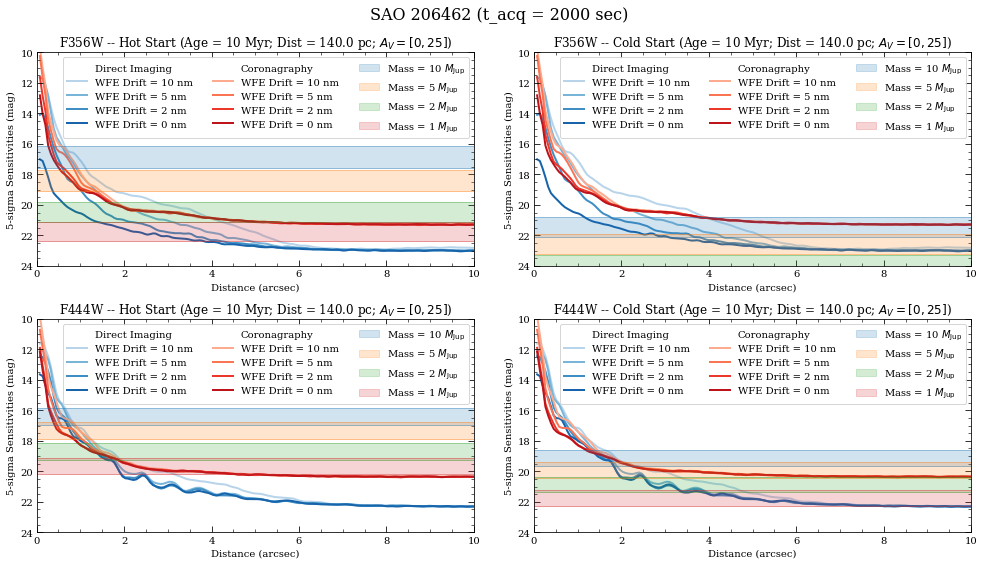

In [224]:
# TW Hya + G4V
do_plot(ylim=[24,10])

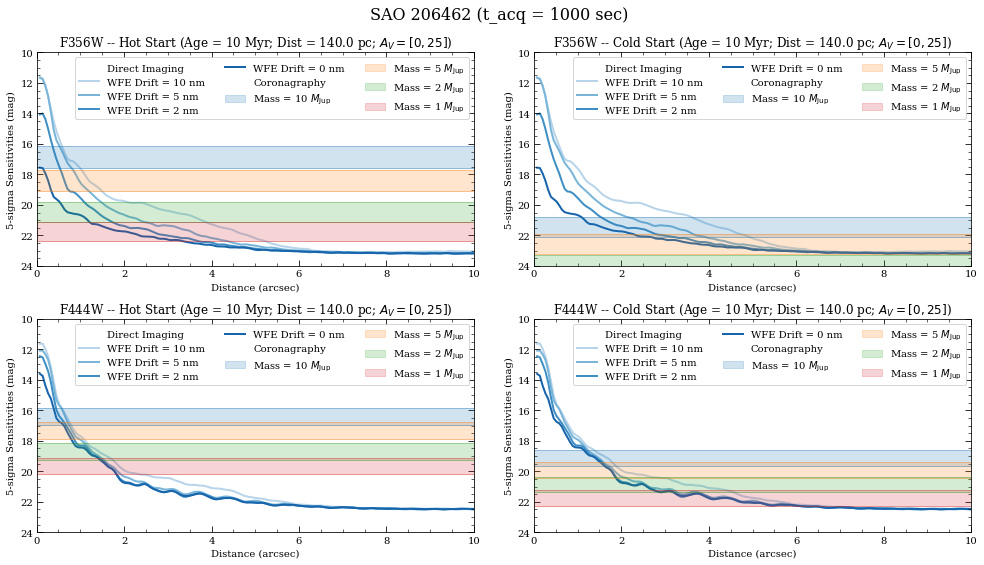

In [269]:
# TW Hya + F3V
do_plot(ylim=[24,10])

In [260]:
obs = obs_dict[filt_keys[1]]
sat_levels = obs.saturation_levels(obs.sp_sci)

In [261]:
print(sat_levels[200-3:200+3,200-2:200+3])
print(sat_levels.max())

[[   8.77790028    7.88800124    7.78392596    7.33514447    6.71324917]
 [   5.87704764   33.82170593   38.65376437    8.46888546    7.53268965]
 [  24.6504662   144.19781263  157.62096953   39.03939261    2.83591757]
 [  28.02818571  153.81876615  168.39703535   44.28534262    2.45344741]
 [   7.07705277   43.59072449   50.08207987   12.22913055    5.36127963]
 [   6.60666576    6.6007932     6.47868295    4.92061023    5.39580557]]
168.397035351


In [136]:
obs = obs_dict[filt_keys[0]]
hdul = obs.gen_roll_image(0,0, opt_diff=True, exclude_disk=True)

In [160]:
data = hdul[0].data
header = hdul[0].header
np.where(data == data.min()) 

(array([200]), array([200]))

In [161]:
sci = obs
ref = obs.nrc_ref

im_star = sci.gen_psf(sci.sp_sci, return_oversample=False)
im_ref = ref.gen_psf(sci.sp_ref, return_oversample=False)

det = sci.Detectors[0]
_im_star = det.pixel_noise(fsrc=im_star)
det = ref.Detectors[0]
_im_ref = det.pixel_noise(fsrc=im_ref)

im_star_rand = np.random.normal(scale=_im_star)
im_ref_rand  = np.random.normal(scale=_im_ref)

In [162]:
extent=np.array([-80,80,-80,80])*obs.pix_scale

(-0.5, 0.5)

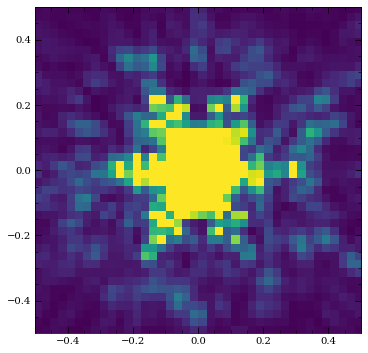

In [266]:
plt.imshow(1*sat_levels, vmin=0., vmax=0.8, 
           extent=extent)
rad = 1/2
plt.xlim([-rad,rad])
plt.ylim([-rad,rad])
#plt.xlim([70,90])
#plt.ylim([70,90])

In [270]:
reload(pynrc.maths.image_manip)
reload(nrc_utils)

<module 'pynrc.nrc_utils' from '/Users/jwstnircam/GitHub/pynrc/nrc_utils.py'>

In [166]:
im1 = im_star + im_star_rand
im2 = im_ref + im_ref_rand

im1_sub = nrc_utils.pad_or_cut_to_size(im1, 50)
im2_sub = nrc_utils.pad_or_cut_to_size(im2, 50)

rho = nrc_utils.dist_image(im1_sub, pixscale=obs.pix_scale)
mask = rho>0.5

scl = nrc_utils.scale_ref_image(im1_sub,im2_sub, mask)

In [167]:
scl

0.29624199867248535

In [168]:
diff1 = im1-im2*scl
diff2 = nrc_utils.optimal_difference(im1,im2,scl)

(-2, 2)

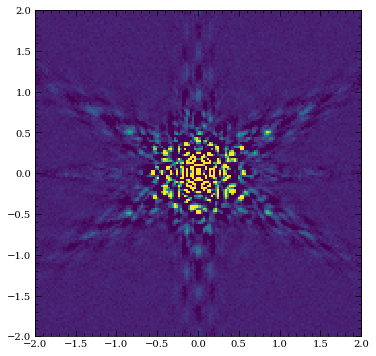

In [170]:
plt.imshow(diff2, vmin=-1, vmax=10, extent=extent)
rad = 2
plt.xlim([-rad,rad])
plt.ylim([-rad,rad])


(-2, 2)

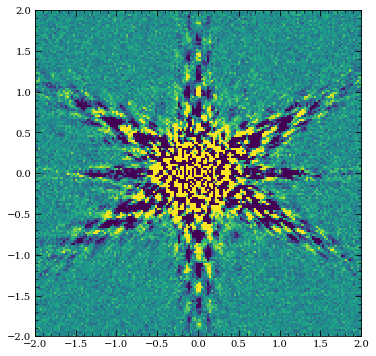

In [135]:
plt.imshow(diff2, vmin=-1, vmax=1, extent=extent)
rad = 2
plt.xlim([-rad,rad])
plt.ylim([-rad,rad])


(-1, 1)

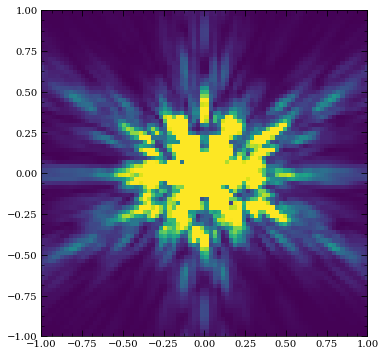

In [132]:
#rho = nrc_utils.dist_image(data)
plt.imshow(im1, vmin=0, vmax=1000, extent=extent)
rad = 1
plt.xlim([-rad,rad])
plt.ylim([-rad,rad])


In [ ]:
# List of WFE drifts to check
wfe_list = [0,2,5,10][::-1]
nsig = 5

# Target acquisition times to check
tacq_list = [500,1000,2000,3000]

save_fig = True
multi_fig = True


fname = outdir + name_sci.replace(" ", "") + '.pdf'
with PdfPages(fname) as pdf:
    for tacq in tacq_list:
        print(name_sci, tacq)
        # Initialize observations
        obs_dict = do_init()
        # Optimize readout parameters
        do_opt(tacq)
        # Get contrasts for each WFE drift
        contrast_all = do_contrast(wfe_list, nsig=nsig)
        # Plot contrast comparisons
        do_plot()

        clear_output(wait=True)


### Remaining Sources

In [ ]:
for i in [1,2,3]:
    
    # Disk model information
    args_disk = None

    name_sci, dist_sci, spt_sci, kmag_sci = args_sources[i]
    name_ref, dist_ref, spt_ref, kmag_ref = ref_sources[i]

    # Science target and reference star spectra
    sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k)
    sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k)
    sp_sci.name = name_sci
    sp_ref.name = name_ref

    # Modify the stellar spectrum so that disk+star = kmag
    if args_disk is not None:
        sp_sci = spec_modify(sp_sci, kmag_sci, args_disk)
        
    # List of WFE drifts to check
    wfe_list = [0,2,5,10][::-1]
    nsig = 5

    # Target acquisition times to check
    tacq_list = [500,1000,2000,3000]

    save_fig = True
    multi_fig = True

    outdir  = '/Volumes/NIRData/'
    fname = outdir + name_sci.replace(" ", "") + '.pdf'
    with PdfPages(fname) as pdf:
        for tacq in tacq_list:
            print(name_sci, tacq)
            # Initialize observations
            obs_dict = do_init()
            # Optimize readout parameters
            do_opt(tacq)
            # Get contrasts for each WFE drift
            contrast_all = do_contrast()
            # Plot contrast comparisons
            do_plot()

            clear_output(wait=True)


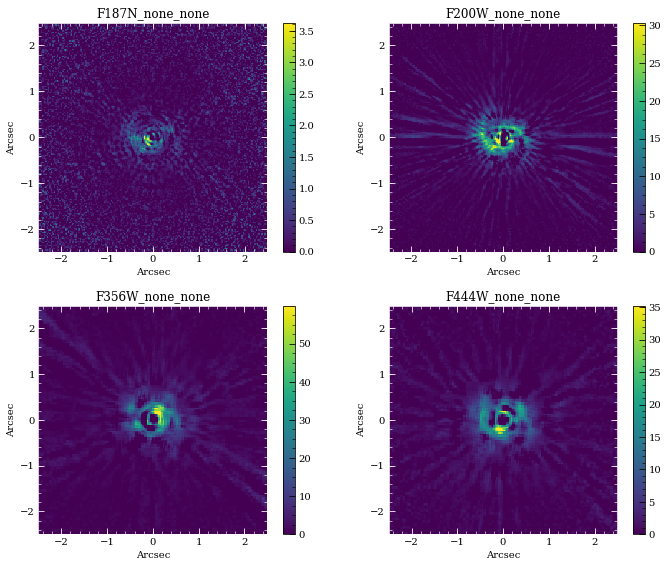

In [12]:
import webbpsf 

fig, axes = plt.subplots(2,2, figsize=(10,8))
axes = axes.flatten()

cmap = matplotlib.rcParams['image.cmap']
for i, ax in enumerate(axes):
    hdulist = final_hdus[i]
    data = hdulist[0].data
    
    vmax = data.max() * 0.75
    vmin = 0 #vmax/10000 #np.min([0,data.min()])
    ax, cb = webbpsf.display_psf(hdulist, ax=ax, title=filt_keys[i], colorbar=True, cmap=cmap,
                                 scale='linear', vmin=vmin, vmax=vmax, imagecrop=5, return_ax=True)
    cb.set_label('')

    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')
    
    ax.minorticks_on()

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')


fig.tight_layout()